Importations et Définitions de la Fonction Rosenbrock

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize_scalar

# --- Définition des fonctions et de leurs gradients ---

# 1. Rosenbrock
def f_rosen(v):
    x, y = v
    return (1 - x)**2 + 100 * (y - x**2)**2

def grad_rosen(v):
    x, y = v
    df_dx = -2 * (1 - x) - 400 * x * (y - x**2)
    df_dy = 200 * (y - x**2)
    return np.array([df_dx, df_dy])





Implémentation des Algorithmes

In [2]:
def gradient_pas_fixe(f, grad_f, x0, rho=0.001, max_iter=1000, tol=1e-6):
    x = np.array(x0, dtype=float)
    history = [] 
    
    # Enregistrement du point initial
    history.append({
        'k': 0,
        'x': x[0],
        'y': x[1],
        'f(x,y)': f(x),
        '||grad f||': np.linalg.norm(grad_f(x)),
        's_k': 0.0
    })
    
    for k in range(1, max_iter + 1):
        g = grad_f(x)
        norm_g = np.linalg.norm(g)
        
        if norm_g < tol:
            break
        
        # Mise à jour
        x = x - rho * g
        val = f(x)
        
        # Enregistrement
        history.append({
            'k': k,
            'x': x[0],
            'y': x[1],
            'f(x,y)': val,
            '||grad f||': norm_g,
            's_k': rho
        })
        
    
    return pd.DataFrame(history)

def gradient_pas_optimal(f, grad_f, x0, max_iter=1000, tol=1e-6):
    x = np.array(x0, dtype=float)
    history = []
    
    # Point initial
    history.append({
        'k': 0,
        'x': x[0],
        'y': x[1],
        'f(x,y)': f(x),
        '||grad f||': np.linalg.norm(grad_f(x)),
        's_k': 0.0
    })
    
    for k in range(1, max_iter + 1):
        g = grad_f(x)
        norm_g = np.linalg.norm(g)
        
        if norm_g < tol:
            break
            
        d = -g
        
        def phi(s):
            return f(x + s * d)
        
        # Recherche linéaire
        res = minimize_scalar(phi, bounds=(0, 2), method='bounded')
        s_k = res.x
        
        x = x + s_k * d
        val = f(x)
        
        history.append({
            'k': k,
            'x': x[0],
            'y': x[1],
            'f(x,y)': val,
            '||grad f||': norm_g, # Norme du gradient précédent
            's_k': s_k
        })
        
    
    return pd.DataFrame(history)

Expérimentation et Visualisation

In [3]:
def analyze_and_plot(f, grad_f, x0, name, rho=0.001, x_bounds=(-2, 2), y_bounds=(-2, 2)):
    print(f"--- ANALYSE : {name} ---")
    
    # 1. Exécution des algorithmes
    df_fixe = gradient_pas_fixe(f, grad_f, x0, rho=rho, max_iter=1000)
    df_opt = gradient_pas_optimal(f, grad_f, x0, max_iter=1000)
    
    # 2. Affichage des tableaux (extrait)
    print(f"\n> Tableau des itérations (Pas Fixe, rho={rho}) :")
    # On affiche le début et la fin pour voir la convergence
    print(pd.concat([df_fixe.head(), df_fixe.tail()])) 
    
    print("\n> Tableau des itérations (Pas Optimal) :")
    print(pd.concat([df_opt.head(), df_opt.tail()]))

    # 3. Graphique
    x = np.linspace(x_bounds[0], x_bounds[1], 400)
    y = np.linspace(y_bounds[0], y_bounds[1], 400)
    X, Y = np.meshgrid(x, y)
    Z = np.array([[f([xi, yi]) for xi in x] for yi in y]) # Calcul grille
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot Pas Fixe
    axes[0].contour(X, Y, Z, levels=50, cmap='viridis')
    axes[0].plot(df_fixe['x'], df_fixe['y'], 'r.-', linewidth=1, markersize=8, label='Trajectoire')
    axes[0].plot(x0[0], x0[1], 'ko', label='Départ')
    axes[0].plot(df_fixe.iloc[-1]['x'], df_fixe.iloc[-1]['y'], 'bx', label='Fin')
    axes[0].set_title(f"{name} - Pas Fixe (rho={rho})")
    axes[0].set_xlabel("x")
    axes[0].set_ylabel("y")
    axes[0].legend()
    axes[0].grid(True, linestyle='--', alpha=0.6)

    # Plot Pas Optimal
    axes[1].contour(X, Y, Z, levels=50, cmap='viridis')
    axes[1].plot(df_opt['x'], df_opt['y'], 'm.-', linewidth=1, markersize=8, label='Trajectoire')
    axes[1].plot(x0[0], x0[1], 'ko', label='Départ')
    axes[1].plot(df_opt.iloc[-1]['x'], df_opt.iloc[-1]['y'], 'bx', label='Fin')
    axes[1].set_title(f"{name} - Pas Optimal (Steepest Descent)")
    axes[1].set_xlabel("x")
    axes[1].set_ylabel("y")
    axes[1].legend()
    axes[1].grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()
    print("-" * 50)

Lancement de l'algorithme

## Justification du Point Initial $x_0 = (-1.2, 1.0)$

La fonction de Rosenbrock est définie par :
$$f(x,y)=(1-x)^{2}+100(y-x^{2})^{2}$$

Son minimum global se situe en $x^* = (1,1)$ où $f(x^*)=0$.

**Analyse du conditionnement :**
La difficulté de cette fonction réside dans la géométrie de sa vallée. Pour le comprendre, analysons la matrice Hessienne $H_f$ au voisinage de l'optimum :
$$
H_f(1,1) = \begin{pmatrix} 802 & -400 \\ -400 & 200 \end{pmatrix}
$$
Les valeurs propres de cette matrice sont approximativement $\lambda_{max} \approx 1001.6$ et $\lambda_{min} \approx 0.4$. Le **nombre de conditionnement** est le rapport $\kappa = \frac{\lambda_{max}}{\lambda_{min}} \approx 2504$.
**Pourquoi ce choix de $x_0$ ?**
Un $\kappa$ aussi élevé indique une vallée extrêmement étroite et courbée. Il est situé dans la vallée parabolique ($y \approx x^2$), mais loin de l'optimum. En démarrant ici, nous forçons l'algorithme de descente à naviguer dans cette vallée mal conditionnée, ce qui met en évidence le phénomène de "zig-zag" (oscillations) lorsque les lignes de niveau sont très étirées.

--- ANALYSE : Rosenbrock ---

> Tableau des itérations (Pas Fixe, rho=0.002) :
         k         x         y     f(x,y)  ||grad f||    s_k
0        0 -1.200000  1.000000  24.200000  232.867688  0.000
1        1 -0.768800  1.176000  37.344901  232.867688  0.002
2        2 -1.121490  0.942021  14.468582  211.622581  0.002
3        3 -0.829744  1.068309  17.775400  158.953420  0.002
4        4 -1.074557  0.916375   9.982348  144.063761  0.002
996    996  0.733054  0.536124   0.071415    0.301316  0.002
997    997  0.733392  0.536622   0.071234    0.300839  0.002
998    998  0.733730  0.537119   0.071054    0.300364  0.002
999    999  0.734067  0.537615   0.070874    0.299889  0.002
1000  1000  0.734403  0.538111   0.070695    0.299416  0.002

> Tableau des itérations (Pas Optimal) :
         k         x         y     f(x,y)  ||grad f||       s_k
0        0 -1.200000  1.000000  24.200000  232.867688  0.000000
1        1  1.440864  2.077904   0.194690  232.867688  0.012249
2        2  1.44

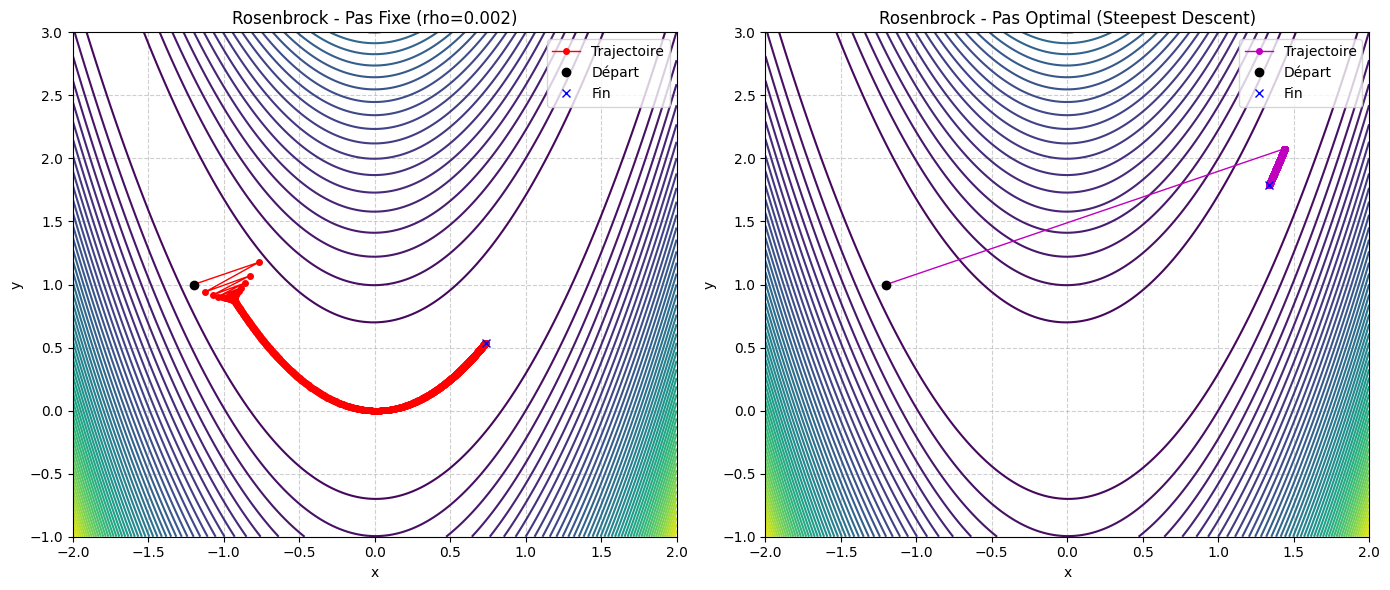

--------------------------------------------------


In [4]:
analyze_and_plot(f_rosen, grad_rosen, x0=[-1.2, 1.0], name="Rosenbrock", rho=0.002, x_bounds=(-2, 2), y_bounds=(-1, 3))

Visualisation comparée des deux descentes de gradient

Visualisation pour Rosenbrock...


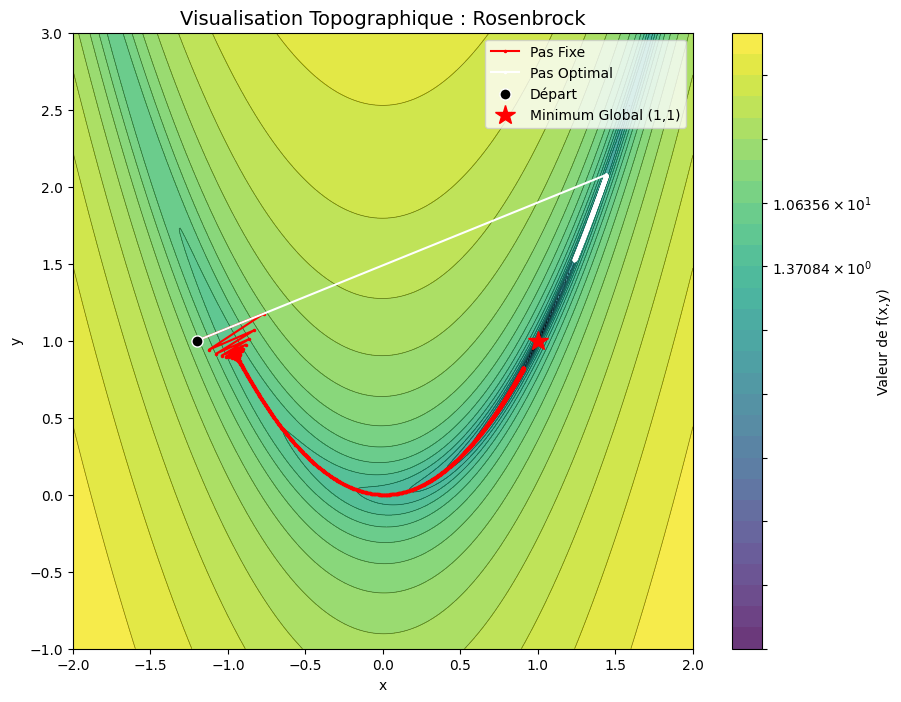

In [8]:
from matplotlib.colors import LogNorm
def visualiser_cuvette(f, path_fixe, path_opt, name, x_bounds, y_bounds, log_scale=False):
    """
    Visualisation améliorée pour voir l'effet 'Cuvette'.
    - Utilise contourf (remplissage) pour la profondeur.
    - Utilise une échelle Logarithmique si demandé (pour Rosenbrock).
    """
    x = np.linspace(x_bounds[0], x_bounds[1], 400)
    y = np.linspace(y_bounds[0], y_bounds[1], 400)
    X, Y = np.meshgrid(x, y)
    
    # Calcul de la grille
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = f([X[i, j], Y[i, j]])

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    # --- ASTUCE : Échelle Logarithmique vs Linéaire ---
    if log_scale and Z.min() > 0:
        # Pour Rosenbrock, on utilise LogNorm pour bien voir le fond de la vallée
        # levels=np.logspace(...) crée des lignes exponentielles
        norm = LogNorm(vmin=Z.min(), vmax=Z.max())
        levels = np.logspace(np.log10(Z.min()), np.log10(Z.max()), 30)
    else:
        # Pour Quadratique et Himmelblau (qui ont des valeurs négatives ou 0)
        norm = None
        levels = 30

    # 1. Le fond coloré (La "Cuvette")
    # cmap='viridis' ou 'turbo' ou 'jet' donne un bon contraste profondeur
    cp = ax.contourf(X, Y, Z, levels=levels, norm=norm, cmap='viridis', alpha=0.8)
    fig.colorbar(cp, label='Valeur de f(x,y)')

    # 2. Les lignes de niveau (Les contours noirs)
    ax.contour(X, Y, Z, levels=levels, norm=norm, colors='black', linewidths=0.5, alpha=0.5)

    # 3. Les trajectoires
    ax.plot(path_fixe['x'], path_fixe['y'], 'r.-', markersize=3, label='Pas Fixe', linewidth=1.5)
    ax.plot(path_opt['x'], path_opt['y'], 'w.-', markersize=3, label='Pas Optimal', linewidth=1.5)
    
    # Points de départ et fin
    start_x, start_y = path_fixe.iloc[0]['x'], path_fixe.iloc[0]['y']
    ax.plot(start_x, start_y, 'ko', markersize=8, label='Départ', markeredgecolor='white')
    
    # Le vrai minimum (pour repère visuel)
    if name == "Rosenbrock":
        ax.plot(1, 1, 'r*', markersize=15, label='Minimum Global (1,1)')
    elif name == "Himmelblau":
        # On affiche un des minima pour l'exemple
        ax.plot(3, 2, 'r*', markersize=15, label='Minima')

    ax.set_title(f"Visualisation Topographique : {name}", fontsize=14)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend()
    ax.set_xlim(x_bounds)
    ax.set_ylim(y_bounds)
    
    plt.show()

df_fixe_rosen = gradient_pas_fixe(f_rosen, grad_rosen, x0=[-1.2, 1.0], rho=0.002, max_iter=2000)
df_opt_rosen = gradient_pas_optimal(f_rosen, grad_rosen, x0=[-1.2, 1.0], max_iter=2000)

print("Visualisation pour Rosenbrock...")
visualiser_cuvette(f_rosen, df_fixe_rosen, df_opt_rosen, "Rosenbrock", (-2, 2), (-1, 3), log_scale=True)

### Analyse des résultats : Fonction de Rosenbrock

**Observations :**
* **Géométrie** : On observe clairement une vallée en forme de banane (courbée). Les lignes de niveau sont très étirées, ce qui indique un mauvais conditionnement du problème.
* **Gradient à Pas Fixe** : L'algorithme progresse, mais nécessite un pas ($\rho$) extrêmement petit pour rester stable. S'il est trop grand, l'algorithme oscille et diverge hors de la vallée. La convergence est très lente.
* **Gradient à Pas Optimal (Steepest Descent)** : Bien que théoriquement meilleur à chaque étape, on observe le phénomène de **"zig-zag"**. Près de la solution, les directions successives du gradient sont orthogonales entre elles, ce qui force l'algorithme à faire de très nombreux petits pas pour avancer au fond de la vallée.

**Conclusion** : La fonction de Rosenbrock illustre les limites des méthodes de premier ordre (gradient simple). Même avec un pas optimal, la convergence est péniblement lente dans les vallées étroites.